In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load & inspect data

In [2]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## checkout histogram of target column

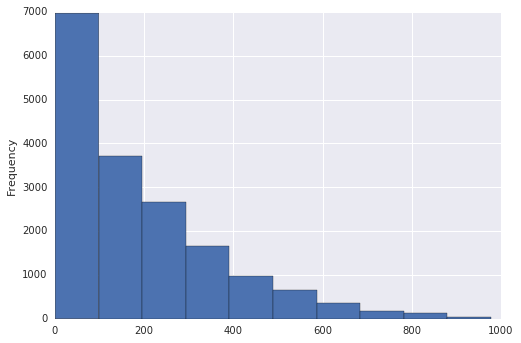

In [3]:
bike_rentals["cnt"] = bike_rentals["cnt"].astype(int)
bike_rentals["cnt"].plot(kind="hist")

## checkout correlations of target column

In [4]:
bike_rentals.corr()[["cnt"]]

,cnt
instant,0.278379
season,0.178056
yr,0.250495
mnth,0.120638
hr,0.394071
holiday,-0.030927
weekday,0.026900
workingday,0.030284
weathersit,-0.142426
temp,0.404772


# Preprocessing

## Feature Engineering

In [5]:
def assign_label(hour: int):
    if  6 <= hour < 12:
        return 1
    elif 12<= hour < 18:
        return 2
    elif 18<= hour <24:
        return 3
    elif 0<= hour <6:
        return 4
    else:
        raise ValueError("input not between 0 and 24")

In [6]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)
bike_rentals[["hr","time_label"]].sample(5)

,hr,time_label
4776,22,3
13189,18,3
3407,21,3
1795,12,2
12990,11,1


## Splitting the Data

**ERROR METRIC**: The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [7]:
# 80% train and 20% test set
train = bike_rentals.sample(frac=0.8, random_state=1)

In [8]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

# Applying different ML models

In [9]:
train_cols = ["season","time_label","yr", "mnth", 
              "holiday", "workingday", "weathersit", "temp", "hum"]

In [10]:
target = "cnt"

In [11]:
X_train = train[train_cols]
y_train = train[target]

X_test = test[train_cols]
y_test = test[target]

## Linear Regression

In [12]:
# train
model = LinearRegression().fit(X_train, y_train)

In [13]:
# predict
predictions = model.predict(X_test)

In [14]:
# MSE
lin_regression_error = mean_squared_error(y_true=y_test, y_pred=predictions)
lin_regression_error

18886.6670130242

The error seems very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## Decision Trees

In [15]:
# train decision tree model
tree_model = DecisionTreeRegressor(min_samples_leaf=8)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [16]:
# predict
predictions_tree = tree_model.predict(X_test)

In [17]:
# error
tree_error = mean_squared_error(y_true=y_test, y_pred=predictions_tree)
tree_error

13652.583547420963

Decision Tree with very few tweaks seems to perform better than Linear Regression.

## Random Forest

In [18]:
# train rf model
forest_model = RandomForestRegressor(min_samples_leaf=5, random_state=0)
forest_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [19]:
# predict
predictions_forest = forest_model.predict(X_test)

In [20]:
# error
forest_error = mean_squared_error(y_true=y_test, y_pred=predictions_forest)
forest_error

11842.942927357708

Random Forest with best performance of all the models. Of course there might be the risk of overfitting due to the lack of cross validation data.